# Визуализация пространства параметров 

Как обычно, начнем с импортирования необходимых библиотек.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Считаем датасет из файла (ничего нового)

In [2]:
data = pd.read_excel('EnergyConsumption.xls')
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,2005-01-01 00:00:00,6,00:00:00,1289.617859,-10.676569
1,2005-01-01 01:00:00,6,01:00:00,1265.573853,-12.041959
2,2005-01-01 02:00:00,6,02:00:00,1273.188232,-13.198006
3,2005-01-01 03:00:00,6,03:00:00,1279.703979,-13.999279
4,2005-01-01 04:00:00,6,04:00:00,1292.839539,-14.782819


Проведем кое-какие манипуляции.

In [3]:
data.Hour = [x.hour for x in data.Hour]
data.Date = [x.toordinal()%365 for x in data.Date]
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,122,6,0,1289.617859,-10.676569
1,122,6,1,1265.573853,-12.041959
2,122,6,2,1273.188232,-13.198006
3,122,6,3,1279.703979,-13.999279
4,122,6,4,1292.839539,-14.782819


Перемешаем строки таблицы. В дальнейшем нам это понадобится.

In [4]:
data = data.sample(frac=1)
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
3296,259,3,8,1078.086792,21.845068
4480,308,3,16,867.886047,28.332346
918,160,2,6,1903.476074,-16.201379
4581,312,7,21,692.986755,18.464511
648,149,5,0,1379.852539,-19.679447


Представим признаки и ответы в виде матриц. Добавим еще признаков. При этом мы сразу отложим 20% от всех объектов в тестовую выборку, оставив лишь 80% для обучения.

In [5]:
train_X = [[row['Date'], row['WeekDay'], row['Hour'], row['TemperatureC']] for i, row in data.iterrows() if i%5 != 0]
train_y = [row['ConsumprionMWtH'] for i, row in data.iterrows() if i%5 != 0]

test_X = [[row['Date'], row['WeekDay'], row['Hour'], row['TemperatureC']] for i, row in data.iterrows() if i%5 == 0]
test_y = [row['ConsumprionMWtH'] for i, row in data.iterrows() if i%5 == 0]

In [6]:
train_X = [np.array([1, x[0], x[0]**2, x[0]**3, x[1], x[1]**2, x[1]**3, x[2], x[2]**2, x[2]**3, x[3]]) for x in train_X]
test_X = [np.array([1, x[0], x[0]**2, x[0]**3, x[1], x[1]**2, x[1]**3, x[2], x[2]**2, x[2]**3, x[3]]) for x in test_X]

Напишем необходимые функции. Новой из них для нас является только bootstrap.

In [7]:
def bootstrap(X, y, K):
    ans = []
    for _ in range(K):
        indexes = np.random.choice(np.arange(len(X)), len(X))
        X1 = []
        y1 = []
        for index in indexes:
            X1.append(X[index])
            y1.append(y[index])
        ans.append((X1, y1))
    return ans

def find_coeffs(X, y):  # обычным МНК находим коэффициенты
    w = np.dot(np.linalg.pinv(X), y)
    return w

def msqr_err(X, w, y): # среднеквадратичная ошибка
    return np.nanmean((np.dot(X, w) - y)**2)

def msqr_err_var(X, w, y, err):
    return np.nanmean((np.dot(X, w) - y)**4) - err**2

Начнем с того, что построим графики зависимости среднеквадратичной ошибки и ее дисперсии от количества объектов в обучающей выборке. Собственно, для этого мы и перемешивали наши строки в таблице. Строки были отсортированы по времени, и если бы мы брали первые N строк, не перемешивая, то наша выборка была бы просто неинформативна.

In [8]:
def draw_graphs(train_X, train_y, low, up, step):
    sample_lens = [int(len(train_X)*q) for q in np.arange(low, up, step)]
    errs = []
    err_vars = []
    for length in sample_lens:
        X = train_X[:length]
        y = train_y[:length]
        w = find_coeffs(X, y)
        errs.append(msqr_err(test_X, w, test_y))
        err_vars.append(msqr_err_var(test_X, w, test_y, errs[-1]))

    plt.xlabel('sample length')
    plt.ylabel('mean error')
    plt.plot(sample_lens, errs)
    plt.show()
    plt.xlabel('sample length')
    plt.ylabel('variance')
    plt.plot(sample_lens, err_vars)
    plt.show()
    plt.xlabel('sample length')
    plt.ylabel('mean error')
    plt.errorbar(sample_lens, errs, err_vars)
    plt.show()

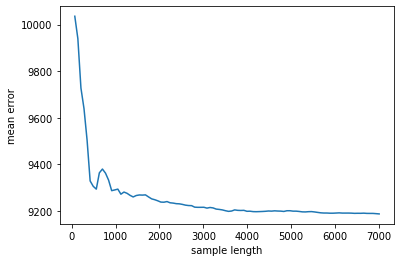

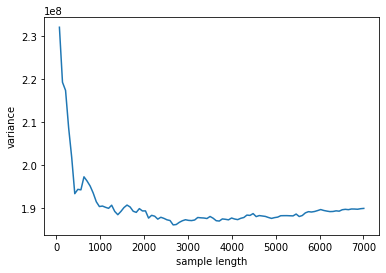

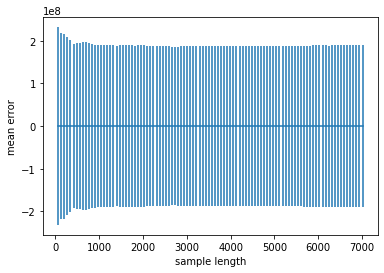

In [9]:
draw_graphs(train_X, train_y, 0.01, 1.01, 0.01)

Как видим, третий график ничего хорошего не дал. Дисперсия ошибки, к сожалению, очень велика, меняется она слабо, лишь в самом начале резко падает вниз, что, в принципе, логично, потому что если информации очень мало, то ошибка не просто очень большая, но ее будет еще и нехило так "колбасить". Давайте отбросим начальный отрезок, чтобы более детально рассмотреть дальнейшее поведение функций.

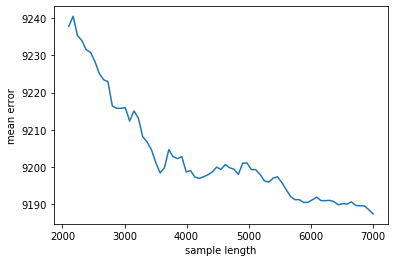

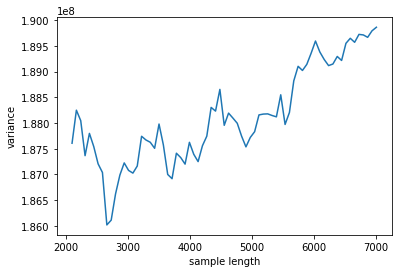

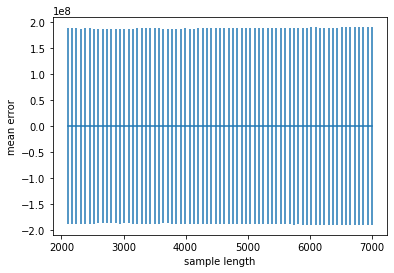

In [10]:
draw_graphs(train_X, train_y, 0.3, 1.01, 0.01)

Что ж, игнорируя третий график, порадуемся тому факту, что первые два вполне отражают наши ожидания: средняя величина ошибки на тестовой выборке действительно падает, дисперсия же растет, хотя и не очень значительно.  
Приступим ко второй части нашего эксперимента, а именно возьмем К выборок, возвращенных функцией bootstrap (попробуем взять К = 10) и вычислим ожидание параметров, дисперсию и ковариацию параметров, ожидание ошибки, дисперсию ошибки.

In [11]:
K = 10
sample = bootstrap(train_X, train_y, K)
weights = []

for X, y in sample:
    weights.append(find_coeffs(X, y))

weights = np.array(weights)
indexes = ['w' + str(i+1) for i in range(len(weights[0]))]
table_means = pd.DataFrame(np.mean(weights, axis=0), index=indexes, columns=['mean val'])
table_cov = pd.DataFrame(np.cov(weights, rowvar=False), index=indexes, columns=indexes)
errs = np.array([msqr_err(sample[i][0], weights[i], sample[i][1]) for i in range(len(sample))])

In [12]:
table_means

,mean val
w1,634.265016
w2,9.963576
w3,-0.060633
w4,0.000093
w5,54.180419
w6,-9.983797
w7,0.046846
w8,84.021687
w9,-2.961961
w10,-0.025797


In [13]:
table_cov

,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11
w1,236.109538,-5.485450e-01,4.027054e-03,-7.402715e-06,-165.792160,44.180013,-3.453158e+00,-1.491383e+01,1.354425e+00,-3.805173e-02,-7.636113e-01
w2,-0.548545,4.881067e-02,-3.133749e-04,5.310296e-07,-0.777367,0.238756,-2.110035e-02,-2.646053e-02,-6.466180e-04,4.530663e-05,3.703607e-02
w3,0.004027,-3.133749e-04,2.031727e-06,-3.466910e-09,0.004019,-0.001242,1.111032e-04,2.336212e-04,-1.059650e-07,-2.168588e-07,-2.382100e-04
w4,-0.000007,5.310296e-07,-3.466910e-09,5.947878e-12,-0.000006,0.000002,-1.616036e-07,-4.748538e-07,5.132055e-09,2.860706e-10,4.021344e-07
w5,-165.792160,-7.773673e-01,4.018530e-03,-5.737463e-06,175.154054,-48.945022,3.958181e+00,6.613625e+00,-5.925210e-01,1.865633e-02,-3.085747e-01
w6,44.180013,2.387562e-01,-1.241690e-03,1.784624e-06,-48.945022,13.819498,-1.125618e+00,-1.601699e+00,1.413055e-01,-4.578230e-03,1.045638e-01
w7,-3.453158,-2.110035e-02,1.111032e-04,-1.616036e-07,3.958181,-1.125618,9.221039e-02,1.121504e-01,-9.437315e-03,3.141089e-04,-1.005172e-02
w8,-14.913827,-2.646053e-02,2.336212e-04,-4.748538e-07,6.613625,-1.601699,1.121504e-01,2.975163e+00,-2.773375e-01,7.316569e-03,2.241183e-02
w9,1.354425,-6.466180e-04,-1.059650e-07,5.132055e-09,-0.592521,0.141305,-9.437315e-03,-2.773375e-01,2.733565e-02,-7.397159e-04,-4.312444e-03
w10,-0.038052,4.530663e-05,-2.168588e-07,2.860706e-10,0.018656,-0.004578,3.141089e-04,7.316569e-03,-7.397159e-04,2.032756e-05,1.364388e-04


In [14]:
print(np.mean(errs))
print(np.std(errs))

9148.912877469123
148.2715226684957


Заметим, что мы не стали выводить дисперсию отдельно, ведь диагональ матрицы ковариаций как раз и является дисперсией.